1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

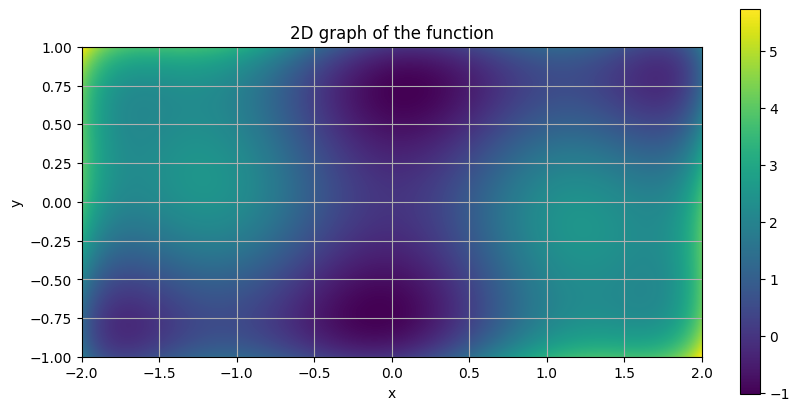


As we can see from the graph, there are two gloabal minima


The frist (x0 = 0, y0 = 0.25) global mimimum found is: 
x =  -0.08984282182881702 
y =  0.7126561771132103
In this point the value of the function is:  -1.0316284534867268

The second (x0 = 0, y0 = -0.25) global mimimum found is: 
x =  0.08984281437300363 
y =  -0.7126561866346983
In this point the value of the function is:  -1.0316284534868174

If the starting point is the origin we obtain 
   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0
        x: [ 0.000e+00  0.000e+00]
      nit: 0
      jac: [ 4.000e-08 -4.000e-08]
     nfev: 3
     njev: 1
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

The method makes an error since it gives as output the origin


In [1]:
import numpy as np 
from scipy import optimize 
import matplotlib.pylab
import matplotlib.pyplot as plt

def f(params):
    x, y = params
    return (4-2.1*x**2+(x**4)/3)*x**2 + x*y + (4*y**2-4)*y**2

x = np.linspace(-2,2,1000)
y = np.linspace(-1,1,1000)

xx, yy = np.meshgrid(x,y)
grid = f((xx, yy))

fig, ax = plt.subplots(figsize=(10,5))
ax.grid('True')
ax.set_title('2D graph of the function')
ax.set_xlabel('x')
ax.set_ylabel('y')
image = plt.imshow(grid, extent=[-2,2,-1,1])
cbar = plt.colorbar(image)
plt.show()

print('\nAs we can see from the graph, there are two gloabal minima\n')

minimum1 = optimize.minimize(f, x0=[0,0.25], bounds=((-2,2),(-1,1)))
print('\nThe frist (x0 = 0, y0 = 0.25) global mimimum found is: \nx = ', minimum1.x[0], '\ny = ', minimum1.x[1])
print('In this point the value of the function is: ', f((minimum1.x[0], minimum1.x[1])))

minimum2 = optimize.minimize(f, x0=[0,-0.25], bounds=((-2,2),(-1,1)))
print('\nThe second (x0 = 0, y0 = -0.25) global mimimum found is: \nx = ', minimum2.x[0], '\ny = ', minimum2.x[1])
print('In this point the value of the function is: ', f((minimum2.x[0], minimum2.x[1])))

minimum3 = optimize.minimize(f, x0=[0,0], bounds=((-2,2),(-1,1)))
print('\nIf the starting point is the origin we obtain \n',minimum3)
print('\nThe method makes an error since it gives as output the origin')

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

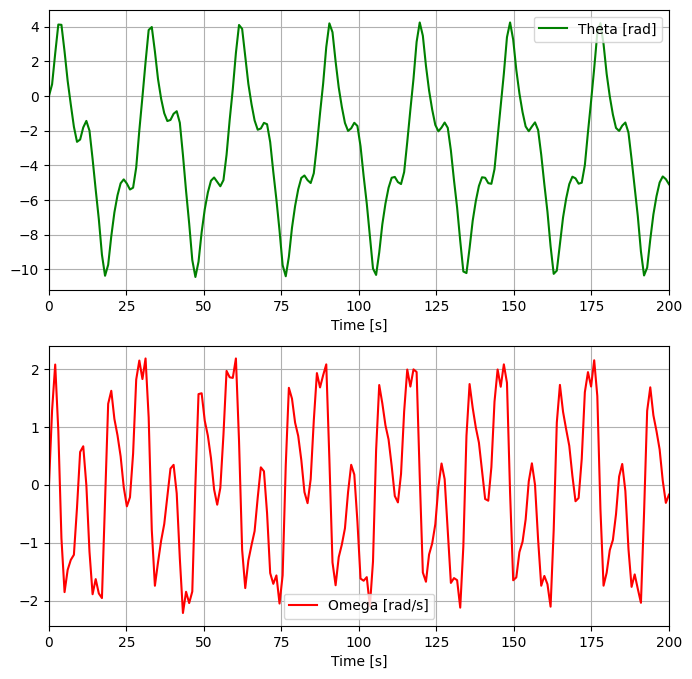

In [68]:
from scipy.integrate import odeint

l = 10
Q = 2
d = 1.5
omega0 = 0
theta0 = 0
om = 0.65
time = np.linspace(0, 200, 200)
Xinit = (theta0, omega0)

def derivative(X, time, l, Q, d, om):
    return (X[1], -1/Q*X[1]+(9.81/l)*np.sin(X[0])+d*np.cos(om*time))

X = odeint(derivative, Xinit, time, args=(l, Q, d, om))

fig, axs = plt.subplots(2,1,figsize=(8,8))
axs[0].plot(time, X[:,0], color='green', label='Theta [rad]')
axs[1].plot(time, X[:,1], color='red', label='Omega [rad/s]')

axs[0].grid('True')
axs[1].grid('True')
axs[0].set_xlim(0,200)
axs[1].set_xlim(0,200)
axs[0].set_xlabel('Time [s]')
axs[1].set_xlabel('Time [s]')
axs[0].legend()
axs[1].legend()
plt.show()

## 3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

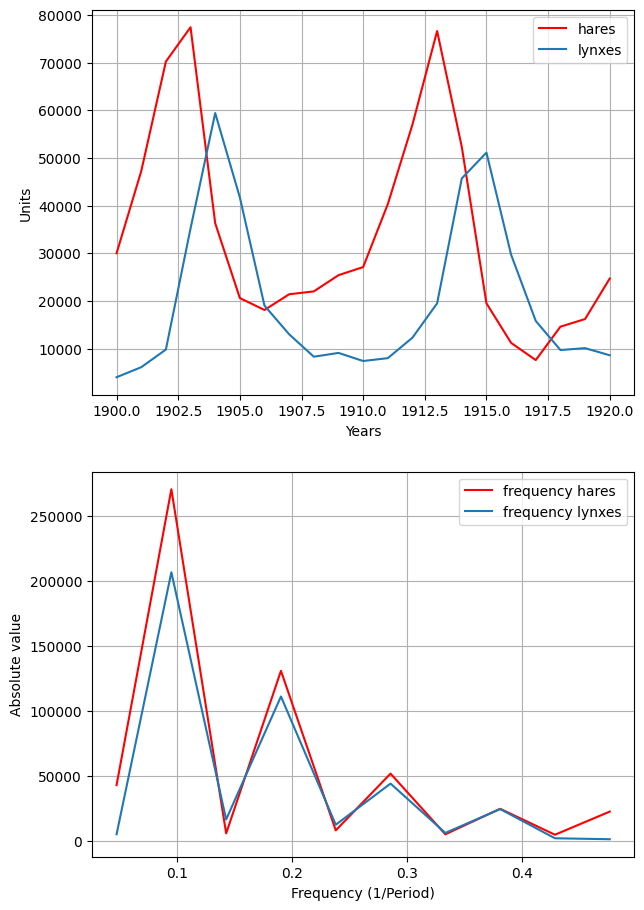


The periodicity for the hares is  10.5  years
The periodicity of the lynxes is  10.5  years


In [110]:
#!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/
from scipy import fftpack

data = np.loadtxt('data/populations.txt')
year, hares, lynxes, carrots = data.T
#!cat data/populations.txt

fig, axs = plt.subplots(2,1,figsize=(7,11))
axs[0].plot(year, hares, label='hares', color='red')
axs[0].plot(year, lynxes, label='lynxes')
axs[0].set_xlabel('Years')
axs[0].set_ylabel('Units')
axs[0].legend()
axs[0].grid('True')


powers_hares = np.abs(fftpack.fft(hares))
powers_lynxes = np.abs(fftpack.fft(lynxes))

sample_freq = fftpack.fftfreq(len(year), d=1)

pos_mask = np.where(sample_freq > 0)
pos_sample_freq = sample_freq[pos_mask]
powers_hares = powers_hares[pos_mask]
powers_lynxes = powers_lynxes[pos_mask]

axs[1].plot(pos_sample_freq, powers_hares, label='frequency hares', color='red')
axs[1].plot(pos_sample_freq, powers_lynxes, label='frequency lynxes')
axs[1].set_xlabel('Frequency (1/Period)')
axs[1].set_ylabel('Absolute value')
axs[1].legend()
axs[1].grid('True')
plt.show()

main_freq_hares = pos_sample_freq[powers_hares.argmax()]
main_freq_lynxes = pos_sample_freq[powers_lynxes.argmax()]
print('\nThe periodicity for the hares is ', 1/main_freq_hares,' years')
print('The periodicity of the lynxes is ', 1/main_freq_lynxes, ' years')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

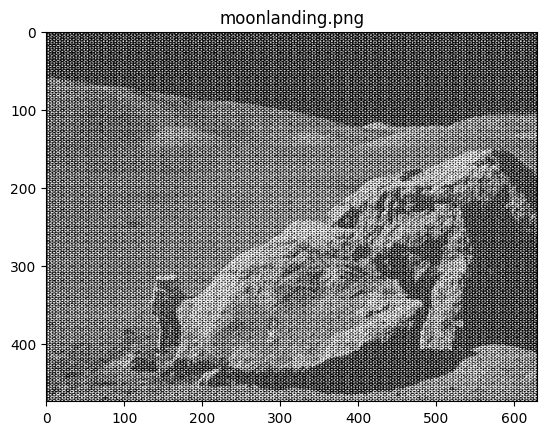

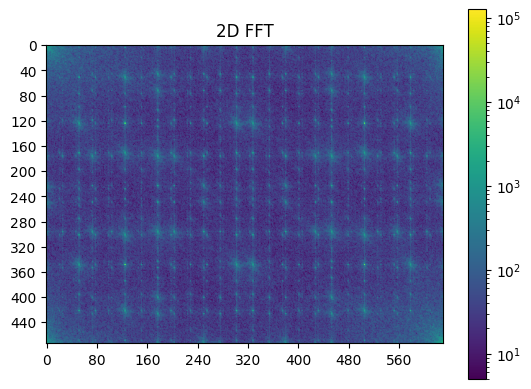

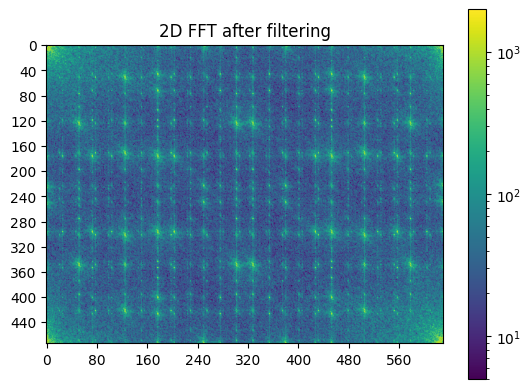

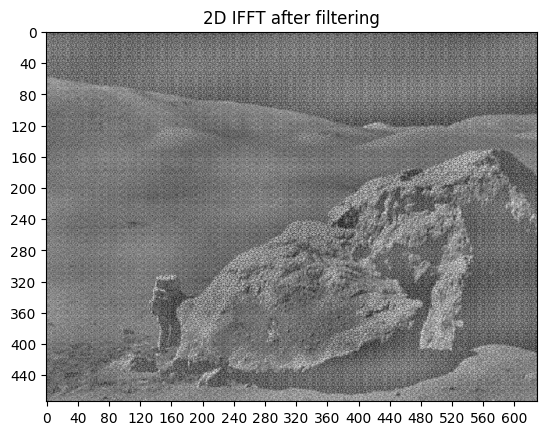

In [372]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import fftpack
from matplotlib.ticker import MultipleLocator

name = 'moonlanding.png'
image = plt.imread(name)  
plt.imshow(image, cmap='grey')
plt.title('moonlanding.png')
plt.show()

fft2d = fftpack.fft2(image)
plt.imshow(np.abs(fft2d), norm=LogNorm(vmin=5))
plt.gca().xaxis.set_major_locator(MultipleLocator(80.0))
plt.gca().yaxis.set_major_locator(MultipleLocator(40.0))
plt.title('2D FFT')
plt.colorbar()
plt.show()

the_mask = np.abs(fft2d) > 2000
fft2d[the_mask] = 0

plt.imshow(np.abs(fft2d), norm=LogNorm(vmin=5))
plt.gca().xaxis.set_major_locator(MultipleLocator(80.0))
plt.gca().yaxis.set_major_locator(MultipleLocator(40.0))
plt.title('2D FFT after filtering')
plt.colorbar()
plt.show()

ifft2d = fftpack.ifft2(fft2d).real
plt.imshow(ifft2d, cmap='grey')
plt.gca().xaxis.set_major_locator(MultipleLocator(40.0))
plt.gca().yaxis.set_major_locator(MultipleLocator(40.0))
plt.title('2D IFFT after filtering')
plt.show()

